In [1]:
!pip install -q keras_cv
!pip install -q pycocotools

import os

from tqdm.auto import tqdm
import xml.etree.ElementTree as ET

import tensorflow as tf
from tensorflow import keras

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 2.4 MB/s eta 0:00:00
Using TensorFlow backend


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# For deatails please see: https://keras.io/examples/vision/yolov8/

# Load Data
# Hyperparameters
VER = 4
MODEL = "xs" # yolo_v8_{MODEL}_backbone_coco
SPLIT_RATIO = 0.2
BATCH_SIZE = 4
LEARNING_RATE = 0.001
EPOCH = 50
GLOBAL_CLIPNORM = 10.0
SUB_V = 1

# A dictionary is created to map each class name to a unique numerical identifier
class_ids = [
    "License_Plate",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

# Path to images and annotations
path_images = "/content/drive/MyDrive/goit_python_data_science/prj/raw_datasets/mixed_v3.1/images"
path_annot = "/content/drive/MyDrive/goit_python_data_science/prj/raw_datasets/mixed_v3.1/annotations"

# Get all XML file paths in path_annot and sort them
xml_files = sorted(
    [
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".xml")
    ]
)

# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".jpg")
    ]
)

# The function below reads the XML file and finds the image name and path,
# and then iterates over each object in the XML file to extract
# the bounding box coordinates and class labels for each object.
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(path_images, image_name)

    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids


image_paths = []
bbox = []
classes = []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)

# In this case, the bbox and classes lists have different lengths for each image,
# depending on the number of objects in the image and the corresponding bounding
# boxes and classes. To handle this variability, ragged tensors are used instead
# of regular tensors.
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

# Determine the number of validation samples
num_val = int(len(data) * SPLIT_RATIO)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)

def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}


# Data Augmentation
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        # keras_cv.layers.RandomShear(
        #     x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        # ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        ),
    ]
)

# Creating Training Dataset
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

# Creating Validation Dataset
resizing = keras_cv.layers.Resizing(
    640,
    640,
    pad_to_aspect_ratio=True,
    bounding_box_format="xyxy",
)
val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

def dict_to_tuple(inputs):
    # return inputs["images"], inputs["bounding_boxes"]
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=8
    )

# We need to extract the inputs from the preprocessing dictionary and get them ready to be fed into the model.
train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)


  0%|          | 0/1334 [00:00<?, ?it/s]

In [4]:
# Creating Model
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    f"yolo_v8_{MODEL}_backbone_coco"
)

yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=1,
)

# Compile the Model
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)


100%|██████████| 645/645 [00:00<00:00, 765kB/s]


100%|██████████| 5.11M/5.11M [00:00<00:00, 20.1MB/s]
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


In [5]:
# yolo = keras.models.load_model('yolo_m_v2.1_e0.keras', compile=False)

# optimizer = tf.keras.optimizers.Adam(
#     learning_rate=LEARNING_RATE,
#     global_clipnorm=GLOBAL_CLIPNORM,
# )

# yolo.compile(
#     optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
# )

In [11]:
# We will be using BoxCOCOMetrics from KerasCV to evaluate the model and calculate
# the Map(Mean Average Precision) score, Recall and Precision.
# We also save our model when the mAP score improves.
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs


In [12]:
# Train the Model
yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCH,
    callbacks=[EvaluateCOCOMetricsCallback(val_ds, f"/content/drive/MyDrive/goit_python_data_science/prj/yolo_{MODEL}_v{VER}_best.keras")],
)


Epoch 1/50
267/267 [==============================] - 205s 769ms/step - loss: 1.7467 - box_loss: 1.2086 - class_loss: 0.5381 - val_loss: 2.3342 - val_box_loss: 1.5022 - val_class_loss: 0.8320 - MaP: 0.4895 - MaP@[IoU=50]: 0.8605 - MaP@[IoU=75]: 0.5105 - MaP@[area=small]: 0.1145 - MaP@[area=medium]: 0.5451 - MaP@[area=large]: 0.2735 - Recall@[max_detections=1]: 0.5584 - Recall@[max_detections=10]: 0.5708 - Recall@[max_detections=100]: 0.5708 - Recall@[area=small]: 0.1321 - Recall@[area=medium]: 0.6347 - Recall@[area=large]: 0.2900
Epoch 2/50
267/267 [==============================] - 206s 769ms/step - loss: 1.7497 - box_loss: 1.2178 - class_loss: 0.5320 - val_loss: 2.1951 - val_box_loss: 1.4345 - val_class_loss: 0.7606 - MaP: 0.5086 - MaP@[IoU=50]: 0.8727 - MaP@[IoU=75]: 0.5440 - MaP@[area=small]: 0.1435 - MaP@[area=medium]: 0.5566 - MaP@[area=large]: 0.3347 - Recall@[max_detections=1]: 0.5743 - Recall@[max_detections=10]: 0.5868 - Recall@[max_detections=100]: 0.5868 - Recall@[area=smal

1/1 [==============================] - 1s 550ms/step


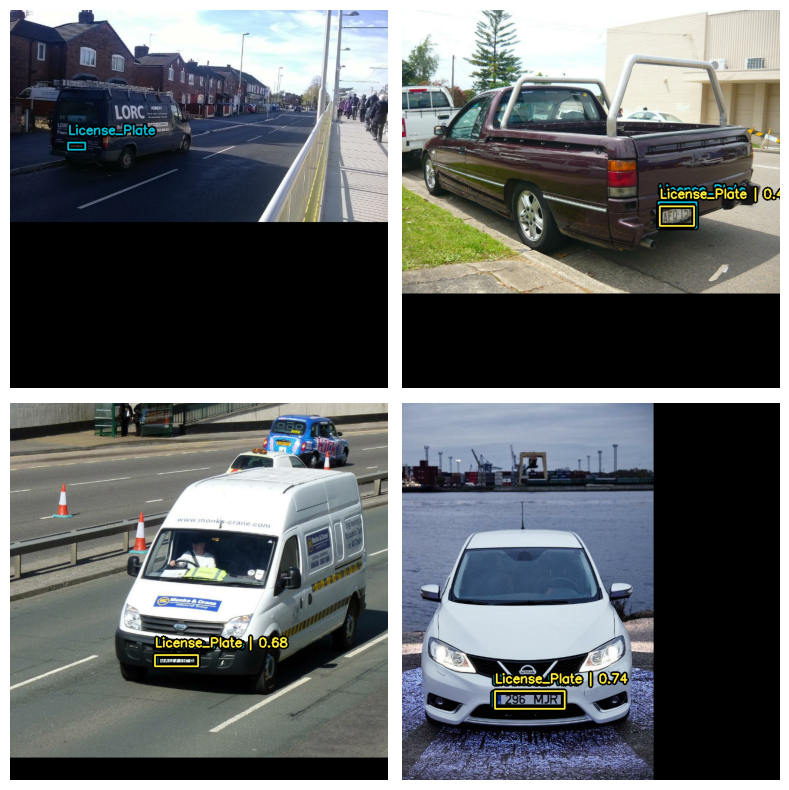

In [10]:
# Visualize Predictions
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    # y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


visualize_detections(yolo, dataset=val_ds, bounding_box_format="xyxy")
